# Unsupervised Learning: Clustering
## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "06_Clustering_Images"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# K-means clustering

## Data preparation

Import and visualize data

In [5]:
customer = pd.read_csv("https://raw.githubusercontent.com/VAWi-DataScience/Data-Science-and-Machine-Learning/main/Lecture/Data/06_Clustering_Data.csv", index_col=0)

customer

,Revenue,Time spend in app
0,-2.698239,1.345470
1,-2.874598,1.809757
2,0.960771,1.170468
3,-2.940323,1.802246
4,-2.724836,1.683585
...,...,...
1995,-2.835657,1.171735
1996,-2.831042,1.816281
1997,-2.803035,2.729481
1998,0.240574,2.401031


Let's visuzalize the data

Saving figure scatterplot_customers


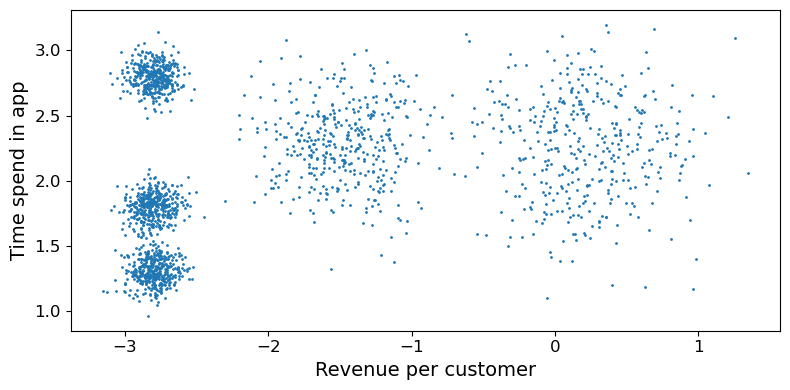

In [6]:
plt.figure(figsize=(8, 4))
plt.scatter(x=customer["Revenue"],y=customer["Time spend in app"], s=1) #make marker size smaller
plt.xlabel("Revenue per customer", fontsize=14)
plt.ylabel("Time spend in app", fontsize=14)
save_fig("scatterplot_customers")
plt.show()

## Performing k-means clustering

**Fit and predict**

In [53]:
from sklearn.cluster import KMeans

In [54]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42) # set random_state for reproducablity
y_pred = kmeans.fit_predict(customer)

Each instance was assigned to one of the 5 clusters:

In [55]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

In [56]:
y_pred is kmeans.labels_

True

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [57]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [58]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0])

Plot cluster results

### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

In [109]:
def plot_data(customer):
    plt.plot(customer["Revenue"], customer["Time spend in app"], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = customer.min(axis=0) - 0.1
    maxs = customer.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Accent")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(customer)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("Revenue per customer", fontsize=14) 
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("Time spend in app", fontsize=14)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


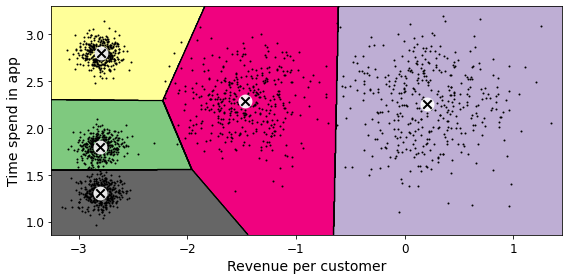

In [110]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, customer)
save_fig("voronoi_plot")
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

### Hard Clustering _vs_ Soft Clustering

In [111]:
temp =pd.concat([pd.DataFrame(customer),pd.DataFrame(kmeans.labels_, columns=['Cluster'])], axis=1)
temp

,Revenue,Time spend in app,Cluster
0,-2.698239,1.345470,4
1,-2.874598,1.809757,0
2,0.960771,1.170468,1
3,-2.940323,1.802246,0
4,-2.724836,1.683585,0
...,...,...,...
1995,-2.835657,1.171735,4
1996,-2.831042,1.816281,0
1997,-2.803035,2.729481,2
1998,0.240574,2.401031,1


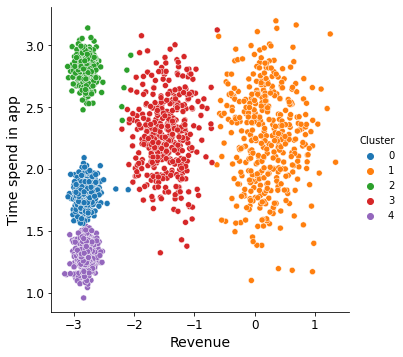

In [112]:
import seaborn as sns
diverging_colors = sns.color_palette("Blues")

sns.pairplot(x_vars=['Revenue'], y_vars=['Time spend in app'], data=temp, hue="Cluster", height=5, palette=sns.color_palette('tab10', n_colors=5))


Of course, we can predict the labels of new instances:

In [22]:
Customer_new = np.array([[0, 2], [-0.5, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(Customer_new)

array([1, 1, 2, 2])

Rather than arbitrarily choosing the closest cluster for each instance, which is called _hard clustering_, it might be better measure the distance of each instance to all 5 centroids. This is what the `transform()` method does:

In [101]:
kmeans.transform(Customer_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [2.31245906, 0.75341366, 2.42727715, 1.00816991, 2.40428294],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

### K-Means Variability

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [113]:
def plot_clusterer_comparison(clusterer1, clusterer2, customer, title1=None, title2=None):
    clusterer1.fit(customer)
    clusterer2.fit(customer)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, customer)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, customer, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


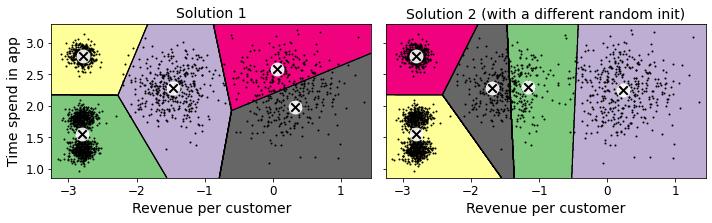

In [114]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=3)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, customer,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure and thinertias of the "good" model we chose above:

In [125]:
kmeans_rnd_init1.inertia_

219.435394427714

In [126]:
kmeans_rnd_init2.inertia_

236.82938799181514

In [115]:
kmeans.inertia_

211.5985372581683

# Finding the right number of clusters

## Heatmap

In [128]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [130]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(kmeans.cluster_centers_)

scaledClusterCenteres = scaler.transform(kmeans.cluster_centers_)
scaledClusterCenteres

array([[-0.73483056, -0.5688039 ],
       [ 1.80143886,  0.33233854],
       [-0.7255758 ,  1.40517516],
       [ 0.3908349 ,  0.3925163 ],
       [-0.7318674 , -1.5612261 ]])

<AxesSubplot:>

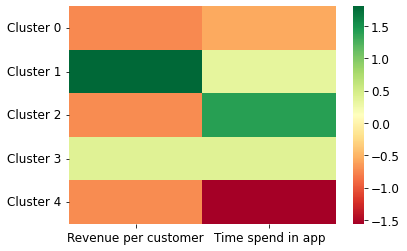

In [132]:
import seaborn as sns
x_labels = ["Revenue per customer","Time spend in app"]
y_labels = ["Cluster 0","Cluster 1","Cluster 2","Cluster 3", "Cluster 4"]
sns.heatmap(scaledClusterCenteres, fmt='.2f', cmap='RdYlGn', xticklabels=x_labels, yticklabels=y_labels)

## Elbow plot

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [118]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(customer) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_plot


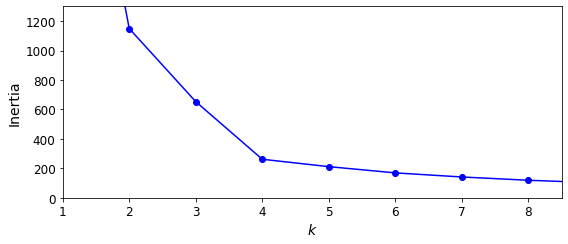

In [119]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

## Silhouette Score

In [122]:
from sklearn.metrics import silhouette_score

In [123]:
silhouette_score(customer, kmeans.labels_)

0.6555176425728281

In [124]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(customer)for k in range(1, 10)]
silhouette_scores = [silhouette_score(customer, model.labels_) for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


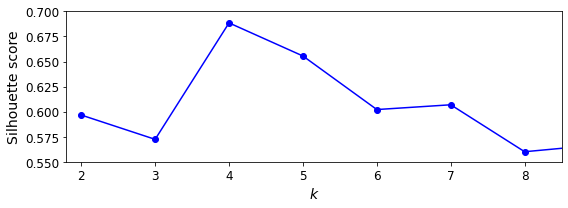

In [125]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

## Silhouette diagram

Saving figure silhouette_analysis_plot


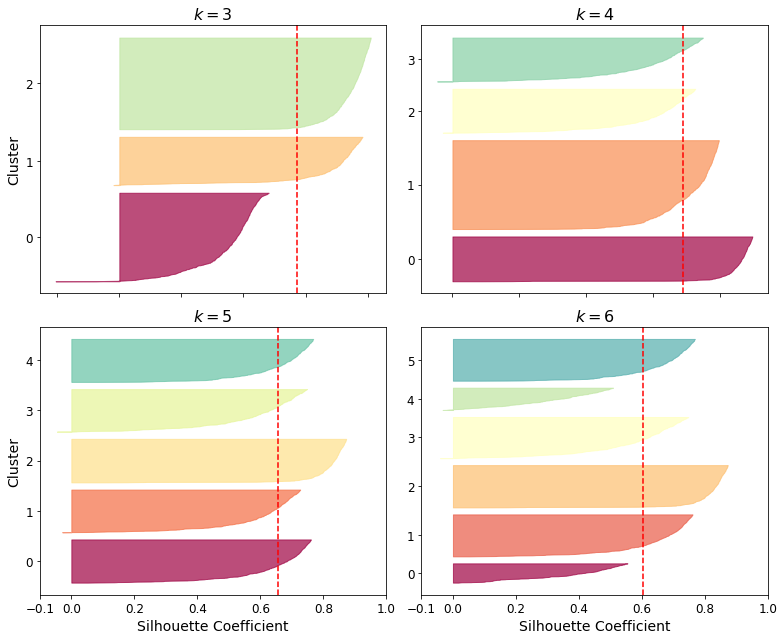

In [127]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(customer)for k in range(1, 10)]

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(customer, y_pred)

    padding = len(customer) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()